In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import skimage.io as skio
import torch.optim as optim
import skimage as sk
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
from torch.optim.lr_scheduler import StepLR

In [3]:
cuda_available = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
data = np.load(f"lego_200x200.npz")
images_train = data["images_train"] / 255.0
c2ws_train = data["c2ws_train"]
images_val = data["images_val"] / 255.0
c2ws_val = data["c2ws_val"]
c2ws_test = data["c2ws_test"]
focal = data["focal"]

In [5]:
height = 200
width = 200
n_samples = 32

In [6]:
K = np.array([[focal,0,width/2],[0,focal,height/2],[0,0,1]])

In [7]:
def transform(c2w, x_c):
    #camera to world
    num_rows = len(x_c)
    ones_column = np.ones((num_rows, 1))
    x_c_with_one = np.concatenate((x_c, ones_column), axis=1)
    x = (c2w @ x_c_with_one.T).T
    return x[:,:-1]

In [8]:
def pixel_to_camera(K, uv,s):
    num_rows = len(uv)
    ones_column = np.ones((num_rows, 1))
    uv_with_one = np.concatenate((uv, ones_column), axis=1)
    result = (np.linalg.inv(K) @ uv_with_one.T).T
    return result

In [9]:
def pixel_to_ray(K, c2w, uv):
    zeros = np.array([[0,0,0]])
    origin = transform(c2w, zeros)
    depth_1_points = pixel_to_camera(K, uv, 1)
    world_depth_1_points = transform(c2w, depth_1_points)
    world_depth_1_points_direction = world_depth_1_points - origin
    norms = np.linalg.norm(world_depth_1_points_direction, axis=1, keepdims=True)
    directions = world_depth_1_points_direction/ norms

    return origin, directions

In [10]:
# images_train[0,:,:]

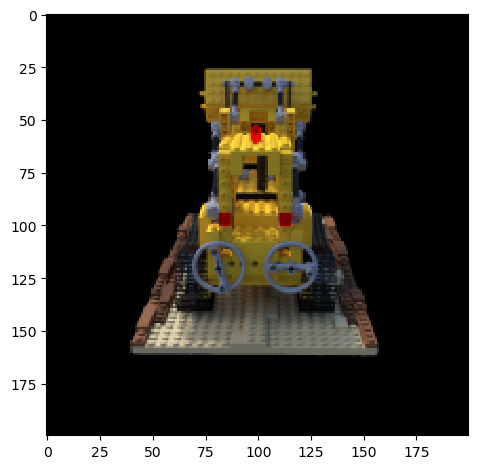

In [11]:
skio.imshow(images_train[0])

In [12]:
import copy

In [13]:
class RaysData(Dataset):
    def __init__(self, img_train, K, c2ws_train):
        self.img = img_train
        self.c2ws = c2ws_train
        self.K = K
        self.height = 200
        self.width = 200
        self.length = len(self.img) * self.height * self.width

    def __len__(self):
        return len(self.img) * self.height * self.width
    
    def __getitem__(self, idx):
        img_index = idx // (self.width*self.height)
        residual = idx % (self.width*self.height)
        temp_height = residual // self.height 
        temp_width = residual % self.width 
        c2w = self.c2ws[img_index]
        uv = np.array([[temp_height+0.5, temp_width+0.5]])
        ray_o, ray_d = pixel_to_ray(self.K, c2w, uv)
        pixel = self.img[img_index,temp_height,temp_width,:]
        sample = {'rays_o':ray_o[0],
                  "rays_d":ray_d[0],
                 "pixels":pixel}
        return sample

    # def generate_sample_pool(self):
    #     self.rays_o = []
    #     self.rays_d = []
    #     self.pixels = []
    #     for index in range(self.__len__()):
    #         img_index = index // (self.width*self.height)
    #         residual = index % (self.width*self.height)
    #         temp_height = residual // self.height 
    #         temp_width = residual % self.width 
    #         c2w = self.c2ws[img_index]
    #         uv = np.array([[temp_height+0.5, temp_width+0.5]])
    #         ray_o, ray_d = pixel_to_ray(self.K, c2w, uv)
    #         self.rays_o.append(ray_o[0])
    #         self.rays_d.append(ray_d[0])
    #         self.pixels.append(self.img[img_index,temp_width,temp_height,:])
    #     self.rays_o = np.array(self.rays_o)
    #     self.rays_d = np.array(self.rays_d)
    #     self.pixels = np.array(self.pixels)
            
    # def sample_rays(self, num_samples):
    #     rays_o = []
    #     rays_d = []
    #     pixels = []
    #     # random_numbers = [random.randint(0,self.length -1) for _ in range(num_samples)]
    #     random_numbers = np.random.randint(0, self.length - 1, size=num_samples) 
    #     for random_number in random_numbers:
    #         img_index = random_number // (self.width*self.height)
    #         residual = random_number % (self.width*self.height)
    #         temp_height = residual // self.height 
    #         temp_width = residual % self.width 
    #         c2w = self.c2ws[img_index]
    #         uv = np.array([[temp_height+0.5, temp_width+0.5]])
    #         ray_o, ray_d = pixel_to_ray(self.K, c2w, uv)
    #         rays_o.append(ray_o[0])
    #         rays_d.append(ray_d[0])
    #         pixels.append(self.img[img_index,temp_height,temp_width,:])
    #     return rays_o, rays_d,pixels


    def generate_sample_pool(self):
        self.rays_o = []
        self.rays_d = []
        self.pixels = []
        for index in range(len(self.img)):
            for i in range(self.height):
                uv = []
                for j in range(self.width):
                    uv.append([i+0.5,j+0.5])
                ray_o, ray_d = pixel_to_ray(K, self.c2ws[index], uv)
                rays_o = np.repeat(ray_o, self.height, axis=0)
                rays_d = list(ray_d)
                rays_o = list(rays_o)
                pixels = self.img[index,:,i,:]
                pixels = list(pixels)
                self.rays_o += rays_o 
                self.pixels += pixels
                self.rays_d += rays_d
        self.rays_o = np.array(self.rays_o)
        self.rays_d = np.array(self.rays_d)
        self.pixels = np.array(self.pixels)
    
    def sample_rays(self, num_samples):
        # rays_o = []
        # rays_d = []
        # pixels = []
        # # random_numbers = [random.randint(0,self.length -1) for _ in range(num_samples)]
        # random_numbers = np.random.randint(0, self.length - 1, size=num_samples)
        random_numbers = []
        for i in range(len(self.img)):
            random_number = np.random.choice(self.height*self.width, (num_samples//len(self.img)+1), replace=False)
            random_number += int(i * self.height*self.width)
            random_number = list(random_number)
            random_numbers += random_number
        random_numbers = np.array(random_numbers)
        # for random_number in random_numbers:
        #     img_index = random_number // (self.width*self.height)
        #     residual = random_number % (self.width*self.height)
        #     temp_height = residual // self.height 
        #     temp_width = residual % self.width 
        #     c2w = self.c2ws[img_index]
        #     uv = np.array([[temp_height+0.5, temp_width+0.5]])
        #     ray_o, ray_d = pixel_to_ray(self.K, c2w, uv)
        #     rays_o.append(ray_o[0])
        #     rays_d.append(ray_d[0])
        #     pixels.append(self.img[img_index,temp_height,temp_width,:])
        return self.rays_o[random_numbers], self.rays_d[random_numbers], self.pixels[random_numbers]

    def sample_rays_one(self, num_samples):
        # rays_o = []
        # rays_d = []
        # pixels = []
        # # random_numbers = [random.randint(0,self.length -1) for _ in range(num_samples)]
        # random_numbers = np.random.randint(0, self.height*self.width, size=num_samples) 
        random_numbers = np.random.choice(self.height*self.width,num_samples, replace=False)
        # random_numbers = [i for i in range(self.height*self.width)]
        # for random_number in random_numbers:
        #     img_index = random_number // (self.width*self.height)
        #     residual = random_number % (self.width*self.height)
        #     temp_height = residual // self.height 
        #     temp_width = residual % self.width 
        #     c2w = self.c2ws[img_index]
        #     uv = np.array([[temp_height+0.5, temp_width+0.5]])
        #     ray_o, ray_d = pixel_to_ray(self.K, c2w, uv)
        #     rays_o.append(ray_o[0])
        #     rays_d.append(ray_d[0])
        #     pixels.append(self.img[img_index,temp_height,temp_width,:])
        return self.rays_o[random_numbers], self.rays_d[random_numbers], self.pixels[random_numbers]

In [12]:
# aaa =   torch.ones(100, 32) * torch.rand(1)*(6 - 2 )/ n_samples 

In [14]:
def sample_along_rays(rays_o, rays_d, n_samples=32, perturb=True):
    far = 6 
    near = 2
    
    t_values = torch.linspace(near, far, n_samples).to(device)
    # ran_values = (torch.rand((len(rays_o), n_samples)) * (far - near) / n_samples).to(device)
    ran_values = torch.ones(len(rays_o), n_samples) * torch.rand(1)*(far - near) / n_samples 
    ran_values = ran_values.to(device)
    # Create 3D grid for rays_o and rays_d
    ray_o_grid = rays_o[:, None, :].repeat(1, n_samples, 1)
    ray_d_grid = rays_d[:, None, :].repeat(1, n_samples, 1)

    # Compute points without explicit loops
    if perturb:
        p_t = t_values + ran_values
    else:
        p_t = t_values + ran_values*0
    p_t = p_t.to(device)
    points = ray_o_grid + ray_d_grid * p_t.unsqueeze(2)

    return points.view(-1, 3)

In [15]:
dataset = RaysData(images_train, K, c2ws_train)
dataset.generate_sample_pool()

In [111]:
rays_o, rays_d, pixels = dataset.sample_rays(10)

In [32]:
len(rays_o)

100

In [13]:
# dataset = RaysData(images_train, K, c2ws_train)
# dataset.generate_sample_pool()
# dataloader = DataLoader(dataset, batch_size=100,
#                         shuffle=True)

In [71]:
rays_o, rays_d, pixels = dataset.sample_rays_one(10)

In [72]:
rays_o

array([[-0.05379832,  3.84547043,  1.20808232],
       [-0.05379832,  3.84547043,  1.20808232],
       [-0.05379832,  3.84547043,  1.20808232],
       [-0.05379832,  3.84547043,  1.20808232],
       [-0.05379832,  3.84547043,  1.20808232],
       [-0.05379832,  3.84547043,  1.20808232],
       [-0.05379832,  3.84547043,  1.20808232],
       [-0.05379832,  3.84547043,  1.20808232],
       [-0.05379832,  3.84547043,  1.20808232],
       [-0.05379832,  3.84547043,  1.20808232]])

In [70]:
# rays_d

In [21]:
# rays_d = torch.tensor(rays_d).float().to(device)
# rays_o = torch.tensor(rays_o).float().to(device)

In [73]:

# import viser, time  # pip install viser
# import numpy as np

# # --- You Need to Implement These ------
# # dataset = RaysData(images_train, K, c2ws_train)
# rays_o, rays_d, pixels = dataset.sample_rays_one(10)
# rays_d = torch.tensor(rays_d).float().to(device)
# rays_o = torch.tensor(rays_o).float().to(device)
# points = sample_along_rays(rays_o, rays_d, perturb=False)
# H, W = images_train.shape[1:3]

In [74]:
# points = points.detach().cpu().numpy()
# rays_o = rays_o.detach().cpu().numpy()
# rays_d = rays_d.detach().cpu().numpy()

In [75]:
# server = viser.ViserServer(share=True)
# for i, (image, c2w) in enumerate(zip(images_train, c2ws_train)):
#     server.add_camera_frustum(
#         f"/cameras/{i}",
#         fov=2 * np.arctan2(H / 2, K[0, 0]),
#         aspect=W / H,
#         scale=0.15,
#         wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
#         position=c2w[:3, 3],
#         image=image
#     )
# for i, (o, d) in enumerate(zip(rays_o, rays_d)):
#     server.add_spline_catmull_rom(
#         f"/rays/{i}", positions=np.stack((o, o + d * 6.0)),
#     )
# server.add_point_cloud(
#     f"/samples",
#     colors=np.zeros_like(points).reshape(-1, 3),
#     points=points.reshape(-1, 3),
#     point_size=0.02,
# )
# time.sleep(1000)

(viser) Share URL requested! (expires in 24 hours)

╭───────────────────────── viser ──────────────────────────╮
│             ╷                                            │
│   HTTP      │ http://0.0.0.0:8082                        │
│   Websocket │ ws://0.0.0.0:8082                          │
│   Share URL │ https://opacity-queue.share.viser.studio   │
│             ╵                                            │
╰──────────────────────────────────────────────────────────╯

(viser) Connection opened (0, 1 total), 416 persistent messages

(viser) Connection closed (0, 0 total)

KeyboardInterrupt: 

In [34]:
# data_iterator = iter(dataloader)
# one_batch = next(data_iterator)
# rays_o, rays_d, pixels = one_batch

# rays_o = one_batch['rays_o'].squeeze()
# rays_d = one_batch['rays_d'].squeeze()
# rays_o = rays_o.float()
# rays_d = rays_d.float()

In [35]:
# import viser, time  # pip install viser
# import numpy as np

# # --- You Need to Implement These ------
# dataset = RaysData(images_train, K, c2ws_train)
# dataloader = DataLoader(dataset, batch_size=100,
#                         shuffle=True)
# data_iterator = iter(dataloader)
# one_batch = next(data_iterator)
# rays_o, rays_d, pixels = one_batch

# rays_o = one_batch['rays_o'].squeeze()
# rays_d = one_batch['rays_d'].squeeze()
# rays_o = rays_o.float().to(device)
# rays_d = rays_d.float().to(device)
# points = sample_along_rays(rays_o, rays_d, perturb=True)
# H, W = images_train.shape[1:3]

In [36]:
# points = points.detach().cpu().numpy()
# rays_o = rays_o.detach().cpu().numpy()
# rays_d = rays_d.detach().cpu().numpy()

In [37]:
# server = viser.ViserServer(share=True)
# for i, (image, c2w) in enumerate(zip(images_train, c2ws_train)):
#     server.add_camera_frustum(
#         f"/cameras/{i}",
#         fov=2 * np.arctan2(H / 2, K[0, 0]),
#         aspect=W / H,
#         scale=0.15,
#         wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
#         position=c2w[:3, 3],
#         image=image
#     )
# for i, (o, d) in enumerate(zip(rays_o, rays_d)):
#     server.add_spline_catmull_rom(
#         f"/rays/{i}", positions=np.stack((o, o + d * 6.0)),
#     )
# server.add_point_cloud(
#     f"/samples",
#     colors=np.zeros_like(points).reshape(-1, 3),
#     points=points.reshape(-1, 3),
#     point_size=0.02,
# )
# time.sleep(1000)

(viser) Share URL requested! (expires in 24 hours)

╭───────────────────────── viser ─────────────────────────╮
│             ╷                                           │
│   HTTP      │ http://0.0.0.0:8082                       │
│   Websocket │ ws://0.0.0.0:8082                         │
│   Share URL │ https://shadow-cheap.share.viser.studio   │
│             ╵                                           │
╰─────────────────────────────────────────────────────────╯

(viser) Connection closed (0, 0 total)

(viser) Connection opened (0, 1 total), 506 persistent messages

(viser) Connection closed (0, 0 total)

KeyboardInterrupt: 

In [16]:
def volrend(sigmas, rgbs, step_size):
    sigmas = sigmas.to(device)
    rgbs = rgbs.to(device)
    size_to_prepend = (sigmas.size(0), 1, 1)

    zeros_to_prepend = torch.zeros(size_to_prepend, dtype=sigmas.dtype).to(device)
    
    tensor_with_zeros = torch.cat((zeros_to_prepend, sigmas), dim=1).to(device)

    
    
    cum_sigmas = torch.cumsum(tensor_with_zeros,dim=1)[:,:-1].to(device)
    T = torch.exp(-cum_sigmas*step_size).to(device)
    interval_sigmas = 1 - torch.exp(-sigmas*step_size).to(device)
    weights = T * interval_sigmas
    colors = rgbs * weights
    cum_colors = torch.sum(colors, dim=1).to(device)

    return cum_colors

In [13]:
# class Residual_block(nn.Module):
#     def __init__(self, dim):
#         super(Residual_block, self).__init__()
#         self.dim = dim
#         self.linear_1 = nn.Linear(dim, dim)
#         self.layer_norm_1 = nn.LayerNorm(normalized_shape=dim)
#         self.relu = nn.ReLU()
#         self.linear_2 = nn.Linear(dim, dim)
#         self.layer_norm_2 = nn.LayerNorm(normalized_shape=dim)
#         nn.init.kaiming_normal_(self.linear_1.weight, mode='fan_in', nonlinearity='relu')
#         nn.init.kaiming_normal_(self.linear_2.weight, mode='fan_in', nonlinearity='relu')

#     def forward(self,x):
#         origin_x = x
#         x = self.linear_1(x)
#         x = self.layer_norm_1(x)
#         x = self.relu(x)
#         x = self.linear_2(x)
#         x = self.layer_norm_2(x)
#         x = self.relu(x + origin_x)
#         return x

In [14]:
# class Nerf_model(nn.Module):
#     def __init__(self,high_fre_level, high_fre_level_angle, hidden_dim):
#         super(Nerf_model, self).__init__()
#         self.high_fre_level = high_fre_level
#         self.high_fre_level_angle = high_fre_level_angle
#         self.pe_dim = 3+high_fre_level*6
#         self.pe_dim_angle = 3 + 6 * high_fre_level_angle
#         self.input_layer = nn.Linear(3+high_fre_level*6, hidden_dim)
#         self.residual_block_1 = Residual_block(hidden_dim)
#         self.residual_block_2 = Residual_block(hidden_dim)
#         self.residual_block_3 = Residual_block(hidden_dim)
        
#         self.hidden_layer_1 = nn.Linear(hidden_dim, hidden_dim)
#         self.hidden_layer_2 = nn.Linear(hidden_dim, hidden_dim)
        
#         self.hidden_layer_concat_angle = nn.Linear(hidden_dim + self.pe_dim_angle, hidden_dim//2)

#         nn.init.kaiming_normal_(self.hidden_layer_concat_angle.weight, mode='fan_in', nonlinearity='relu')
        
#         self.out = nn.Linear(hidden_dim//2, 3)
#         nn.init.kaiming_normal_(self.out.weight, mode='fan_in', nonlinearity='relu')
        
#         self.relu = nn.ReLU()
#         self.sigmoid = nn.Sigmoid()
#         self.density_layer = nn.Linear(hidden_dim, 1)

#         power_terms_pos = (torch.exp2(torch.arange(0, high_fre_level))*3.14159).to(device)
        
#         power_terms_angle = (torch.exp2(torch.arange(0, high_fre_level_angle))*3.14159).to(device)
        
#         self.power_matrix_pos= torch.zeros(3, self.high_fre_level *3).to(device)
#         for i in range(3):
#             self.power_matrix_pos[i,i*high_fre_level:(i+1)*high_fre_level] = power_terms_pos

#         self.power_matrix_angle = torch.zeros(3, self.high_fre_level_angle  *3).to(device)
#         for i in range(3):
#             self.power_matrix_angle[i,i*high_fre_level_angle :(i+1)*high_fre_level_angle ] = power_terms_angle


#         self.middle_layer_norm = nn.LayerNorm(normalized_shape=hidden_dim) 
        
#         self.last_layer_norm = nn.LayerNorm(normalized_shape=hidden_dim//2) 

#     def positional_encoding(self, data, high_fre_level, power_matrix):

#         powered_data = data @ power_matrix
#         sin_matrix = torch.sin(powered_data).to(device)
#         cos_matrix = torch.cos(powered_data).to(device)

#         pe = torch.cat((data, sin_matrix, cos_matrix),1).to(device)

#         return pe

#     def forward(self,pos, angle):
                
#         pos_pe = self.positional_encoding(pos, self.high_fre_level, self.power_matrix_pos)
        
#         origin_x = pos_pe
#         x = self.input_layer(origin_x)
#         x = self.residual_block_1(x)
#         x = self.residual_block_2(x)
#         x = self.residual_block_3(x)
#         x = self.hidden_layer_1(x)
#         sigmas = self.density_layer(x)
#         sigmas = self.relu(sigmas)

#         # x = self.middle_layer_norm(x)
#         x = self.hidden_layer_2(x)

#         angle_pe = self.positional_encoding(angle, self.high_fre_level_angle, self.power_matrix_angle)
#         # angle_input = torch.cat((angle,angle_pe),dim=1)
#         concated_x = torch.cat((x,angle_pe), dim = 1).float()
#         x = self.hidden_layer_concat_angle(concated_x)
#         x = self.last_layer_norm(x)
#         x = self.relu(x)
#         x = self.out(x)
#         x = self.sigmoid(x)
#         return x, sigmas

In [18]:
class Nerf_model(nn.Module):
    def __init__(self,high_fre_level, high_fre_level_angle, hidden_dim):
        super(Nerf_model, self).__init__()
        self.high_fre_level = high_fre_level
        self.high_fre_level_angle = high_fre_level_angle
        self.pe_dim = 3+high_fre_level*6
        self.pe_dim_angle = 3 + 6 * high_fre_level_angle
        self.input_layer = nn.Linear(3+high_fre_level*6, hidden_dim)
        # self.input_layer = nn.Linear(2, hidden_dim)
        hidden_layer_list = []


        
        for i in range(3):
            hidden_layer_list.append(nn.Linear(hidden_dim, hidden_dim))
            hidden_layer_list.append(nn.ReLU())
        self.hidden_layer_1 = nn.Sequential(*hidden_layer_list)

        self.concat_hidden_layer = nn.Linear(hidden_dim + self.pe_dim,hidden_dim)
        
        hidden_layer_list = []
        for i in range(2):
            hidden_layer_list.append(nn.Linear(hidden_dim, hidden_dim))
            hidden_layer_list.append(nn.ReLU())
        self.hidden_layer_2 = nn.Sequential(*hidden_layer_list)

        self.hidden_layer_3 = nn.Linear(hidden_dim, hidden_dim)
        self.hidden_layer_4 = nn.Linear(hidden_dim, hidden_dim)
        self.hidden_layer_5 = nn.Linear(hidden_dim, hidden_dim)
        self.hidden_layer_concat_angle = nn.Linear(hidden_dim + self.pe_dim_angle, hidden_dim//2)

        self.out = nn.Linear(hidden_dim//2, 3)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.density_layer = nn.Linear(hidden_dim, 1)
        
        power_terms_pos = (torch.exp2(torch.arange(0, high_fre_level))*3.14159).to(device)
        
        power_terms_angle = (torch.exp2(torch.arange(0, high_fre_level_angle))*3.14159).to(device)
        
        self.power_matrix_pos= torch.zeros(3, self.high_fre_level *3).to(device)
        for i in range(3):
            self.power_matrix_pos[i,i*high_fre_level:(i+1)*high_fre_level] = power_terms_pos

        self.power_matrix_angle = torch.zeros(3, self.high_fre_level_angle  *3).to(device)
        for i in range(3):
            self.power_matrix_angle[i,i*high_fre_level_angle :(i+1)*high_fre_level_angle ] = power_terms_angle

        # self.layer_norm1 = nn.LayerNorm(normalized_shape=HIDDEN_UNITS)  
        # self._initialize_weights()
        self.last_layer_norm = nn.LayerNorm(normalized_shape=hidden_dim//2) 
        

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)


    


    def positional_encoding(self, data, high_fre_level, power_matrix):

        powered_data = data @ power_matrix
        sin_matrix = torch.sin(powered_data).to(device)
        cos_matrix = torch.cos(powered_data).to(device)

        pe = torch.cat((data, sin_matrix, cos_matrix),1).to(device)

        return pe




    
    def forward_phase_1(self, origin_x):

        x = self.input_layer(origin_x)
        x = self.relu(x)
        x = self.hidden_layer_1(x)
        x = torch.cat((x,origin_x), dim = 1)
        x = self.concat_hidden_layer(x)
        x = self.relu(x)
        x = self.hidden_layer_2(x)
        x = self.hidden_layer_3(x)
        return x


        
    def forward(self, pos, angle):
        
        pos_pe = self.positional_encoding(pos, self.high_fre_level, self.power_matrix_pos)
        
        origin_x = pos_pe
        x = self.forward_phase_1(origin_x)




        
        sigmas = self.density_layer(x)
        sigmas = self.relu(sigmas)
        
        x = self.hidden_layer_4(x)
        angle_pe = self.positional_encoding(angle, self.high_fre_level_angle, self.power_matrix_angle)
        # angle_input = torch.cat((angle,angle_pe),dim=1)
        concated_x = torch.cat((x,angle_pe), dim = 1).float()
        x = self.hidden_layer_concat_angle(concated_x)
        # x = self.last_layer_norm(x)
        x = self.relu(x)
        x = self.out(x)
        x = self.sigmoid(x)
        return x, sigmas
        

In [69]:
def calcualte_PSNR():
    model.eval()
    loss_fn = nn.SmoothL1Loss(reduction='sum')
    dataset = RaysData(images_val, K, c2ws_val)
    # dataloader = DataLoader(dataset, batch_size=10000,
    #                     shuffle=True)
    total_loss = 0

    for index in range(len(c2ws_val)):
        eval_height = 200
        eval_width = 200
        # c2w_eval = c2ws_train[index]
        c2w_eval = c2ws_val[index]
        results = np.zeros((eval_height, eval_width,3))
        for i in range(eval_height):
            pixels = []
            uv = []
            for j in range(eval_width):
                uv.append([i,j])
                pixels.append(images_val[index,j,i])
            pixels = torch.tensor(pixels).float().to(device)
            ray_o, ray_d = pixel_to_ray(K, c2w_eval, uv)
            rays_o = np.repeat(ray_o, eval_height, axis=0)
            rays_d = list(ray_d)
        
            rays_o = torch.tensor(rays_o).float().to(device)
            rays_d = torch.tensor(rays_d).float().to(device)
            points = sample_along_rays(rays_o, rays_d, perturb=False)
            points = points.to(device)
            # rays_d = torch.tensor(rays_d).to(device)
            rays_d = torch.unsqueeze(rays_d,1)
            rays_d = rays_d.repeat(1,n_samples,1)
            rays_d = rays_d.view(-1,3)
            
            rgbs, sigmas = model(points, rays_d)
            rgbs = rgbs.to(device)
            sigmas = sigmas.to(device)
            # sigams = model.foward_dentisy()
            sigmas = sigmas.view(-1, n_samples, 1)
            rgbs = rgbs.view(-1, n_samples, 3)
            
            rendered_colors = volrend(sigmas, rgbs, step_size)

            # print(rendered_colors.shape)
            # print(pixels.shape)
            with torch.no_grad():
                total_loss += loss_fn(rendered_colors, pixels).item()
    mse = total_loss/len(c2ws_val)/200/200
    return np.log10(1/mse)*10


In [115]:
weights_path = 'weights_8400.pth'  # Provide the correct path to the saved weights file
model.load_state_dict(torch.load(weights_path))

<All keys matched successfully>

In [64]:
iterations_list = [int(20*i) for i in range(5)] + [int(200 + 50 *i) for i in range(7)] + [int(600 + 100 *i) for i in range(11)]

In [66]:
iterations_list += [int(1800) + 200*i for i in range(33)]

In [ ]:
PSNR_loss_list = []

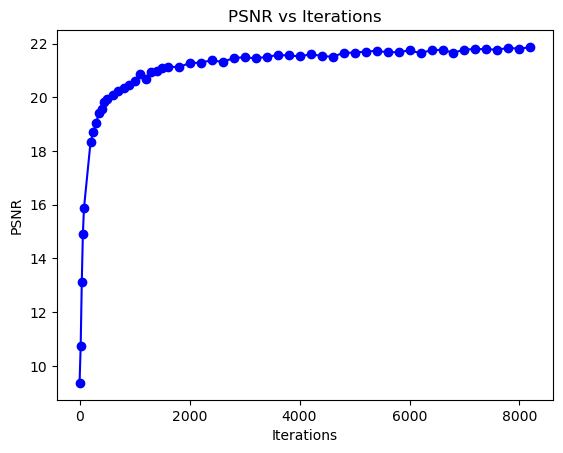

In [114]:
plt.plot(iterations_list, PSNR_loss_list, linestyle='-', marker='o', color='blue', label='Line 1')
plt.xlabel('Iterations')
plt.ylabel('PSNR')
plt.title('PSNR vs Iterations')
plt.savefig("PSNR.jpg")

In [78]:
# for it in iterations_list:
#     print(it)
#     weights_path = 'weights_%s.pth'%it  # Provide the correct path to the saved weights file
#     model.load_state_dict(torch.load(weights_path))
#     PSNR_loss_list.append(calcualte_PSNR())

In [79]:
# PSNR_loss_list

In [76]:
np.save('PSNR.npy', np.array(PSNR_loss_list))

In [77]:
np.save('iterations.npy', np.array(iterations_list))

In [28]:
model = Nerf_model(10,4,256).to(device)
step_size = (6-2)/n_samples

In [29]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [30]:
PSNR_loss_list = []

global_iter = 0

In [115]:
dataset = RaysData(images_train, K, c2ws_train)
dataset.generate_sample_pool()
# rays_o, rays_d, pixels = dataset.sample_rays(10)

In [42]:
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# criterion = PSNRWithMSELoss()
criterion = torch.nn.MSELoss()
number_epoch  = 3
model.train()
# scheduler = StepLR(optimizer, step_size=100, gamma=0.1)
# for i in range(number_iteration):

# dataset = RaysData(images_train, K, c2ws_train)
# dataloader = DataLoader(dataset, batch_size=10000,
#                         shuffle=True)

for e in range(number_epoch):
#     for i_batch, sample_batched in enumerate(tqdm(dataloader)):
    for i in tqdm(range(1000)):
        # print(len(sample_batched['pixels']))
        rays_o, rays_d, pixels = dataset.sample_rays(10000)
        # rays_o, rays_d, pixels = dataset.sample_rays_one(1000)
        # t1 = time.time()
        
        # rays_o = sample_batched['rays_o'].squeeze()
        # rays_d = sample_batched['rays_d'].squeeze()
        # pixels = sample_batched['pixels']
        # rays_o = rays_o.float().to(device)
        # rays_d = rays_d.float().to(device)

        
        # rays_d = np.array(rays_d)
        # rays_o = np.array(rays_o)
        rays_d = torch.tensor(rays_d).float().to(device)
        rays_o = torch.tensor(rays_o).float().to(device)
        points = sample_along_rays(rays_o, rays_d, perturb=False,n_samples=n_samples)
        
    
        points = points.float().to(device)
        # points = np.array(points)
        # rays_d = np.array(rays_d)
        # points = torch.tensor(points).to(device)
        # rays_d = torch.tensor(rays_d).to(device)
    
        rays_d = torch.unsqueeze(rays_d,1)
        rays_d = rays_d.repeat(1,n_samples,1)
        rays_d = rays_d.view(-1,3)
        
        # t2 = time.time()
        # print('p',t2-t1)
        # t1 = t2
        
        rgbs, sigmas = model(points, rays_d)
        
        # t2 = time.time()
        # print('forward',t2-t1)
        # t1 = t2
        
        rgbs = rgbs.to(device)
        sigmas = sigmas.to(device)
        # sigams = model.foward_dentisy()
        sigmas = sigmas.view(-1, n_samples, 1)
        rgbs = rgbs.view(-1, n_samples, 3)
        
    
    
        rendered_colors = volrend(sigmas, rgbs, step_size)

                
        # t2 = time.time()
        # print('render',t2-t1)
        # t1 = t2
        # print("render",rendered_colors[0])
        # print("pixels",pixels[0])
    
        # pixels = pixels.float().to(device)
        # pixels = np.array(pixels)
        pixels = torch.tensor(pixels).float().to(device)
    
        # print(rendered_colors)
        loss = criterion(rendered_colors, pixels)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

                        
        # t2 = time.time()
        # print('backward',t2-t1)
        # t1 = t2
        # scheduler.step()
        # if global_iter % 100 ==0:
        #     PSNR_loss_list.append(calcualte_PSNR())
        #     print(PSNR_loss_list[-1])
        global_iter += 1
        if global_iter % 50 == 0:
            print(f'iteration [{i}], Loss: {loss.item()}')
        if global_iter % 200 == 0:
            torch.save(model.state_dict(), 'weights_%s.pth'%global_iter)
            print('saved')
    # scheduler.step()
    # torch.save(model.state_dict(), 'weights_%s.pth'%e)

  5%|██                                       | 51/1000 [00:11<03:36,  4.38it/s]

iteration [49], Loss: 0.0027394320350140333


 10%|████                                    | 101/1000 [00:23<03:31,  4.25it/s]

iteration [99], Loss: 0.002770728664472699
saved


 15%|██████                                  | 151/1000 [00:35<03:17,  4.31it/s]

iteration [149], Loss: 0.0027346403803676367


 20%|████████                                | 201/1000 [00:47<03:05,  4.31it/s]

iteration [199], Loss: 0.002755938796326518


 25%|██████████                              | 251/1000 [00:59<02:58,  4.19it/s]

iteration [249], Loss: 0.002647453686222434


 30%|████████████                            | 301/1000 [01:11<02:53,  4.02it/s]

iteration [299], Loss: 0.002548855496570468
saved


 35%|██████████████                          | 351/1000 [01:23<02:34,  4.21it/s]

iteration [349], Loss: 0.0028889973182231188


 40%|████████████████                        | 401/1000 [01:35<02:19,  4.29it/s]

iteration [399], Loss: 0.0027688699774444103


 45%|██████████████████                      | 451/1000 [01:47<02:13,  4.12it/s]

iteration [449], Loss: 0.0024769254960119724


 50%|████████████████████                    | 501/1000 [01:59<01:58,  4.20it/s]

iteration [499], Loss: 0.00258895056322217
saved


 55%|██████████████████████                  | 551/1000 [02:10<01:45,  4.28it/s]

iteration [549], Loss: 0.002528680954128504


 60%|████████████████████████                | 601/1000 [02:22<01:33,  4.28it/s]

iteration [599], Loss: 0.0027600396424531937


 65%|██████████████████████████              | 651/1000 [02:34<01:21,  4.28it/s]

iteration [649], Loss: 0.002720649354159832


 70%|████████████████████████████            | 701/1000 [02:47<01:13,  4.06it/s]

iteration [699], Loss: 0.0024750488810241222
saved


 75%|██████████████████████████████          | 751/1000 [02:59<00:58,  4.25it/s]

iteration [749], Loss: 0.0025197407230734825


 80%|████████████████████████████████        | 801/1000 [03:11<00:46,  4.26it/s]

iteration [799], Loss: 0.002540956949815154


 85%|██████████████████████████████████      | 851/1000 [03:23<00:34,  4.27it/s]

iteration [849], Loss: 0.0027215208392590284


 90%|████████████████████████████████████    | 901/1000 [03:35<00:23,  4.18it/s]

iteration [899], Loss: 0.0026112026534974575
saved


 95%|██████████████████████████████████████  | 951/1000 [03:47<00:11,  4.25it/s]

iteration [949], Loss: 0.0028558627236634493


100%|███████████████████████████████████████| 1000/1000 [03:58<00:00,  4.19it/s]


iteration [999], Loss: 0.0028619852382689714


  5%|██                                       | 51/1000 [00:12<03:42,  4.26it/s]

iteration [49], Loss: 0.002474424196407199


 10%|████                                    | 101/1000 [00:23<03:35,  4.18it/s]

iteration [99], Loss: 0.0023864915128797293
saved


 15%|██████                                  | 151/1000 [00:35<03:18,  4.27it/s]

iteration [149], Loss: 0.0025950949639081955


 20%|████████                                | 201/1000 [00:47<03:06,  4.28it/s]

iteration [199], Loss: 0.0025269838515669107


 25%|██████████                              | 251/1000 [00:59<02:55,  4.27it/s]

iteration [249], Loss: 0.0025961308274418116


 30%|████████████                            | 301/1000 [01:11<02:47,  4.19it/s]

iteration [299], Loss: 0.00231842789798975
saved


 35%|██████████████                          | 351/1000 [01:23<02:32,  4.26it/s]

iteration [349], Loss: 0.0024624948855489492


 40%|████████████████                        | 401/1000 [01:35<02:20,  4.27it/s]

iteration [399], Loss: 0.0024680139031261206


 45%|██████████████████                      | 451/1000 [01:46<02:08,  4.27it/s]

iteration [449], Loss: 0.002425819868221879


 50%|████████████████████                    | 501/1000 [01:58<01:59,  4.17it/s]

iteration [499], Loss: 0.002649651374667883
saved


 55%|██████████████████████                  | 551/1000 [02:10<01:44,  4.28it/s]

iteration [549], Loss: 0.002388779539614916


 60%|████████████████████████                | 601/1000 [02:22<01:33,  4.27it/s]

iteration [599], Loss: 0.0023858053609728813


 65%|██████████████████████████              | 651/1000 [02:34<01:21,  4.27it/s]

iteration [649], Loss: 0.0022864348720759153


 70%|████████████████████████████            | 701/1000 [02:46<01:11,  4.18it/s]

iteration [699], Loss: 0.002495208755135536
saved


 75%|██████████████████████████████          | 751/1000 [02:58<00:58,  4.26it/s]

iteration [749], Loss: 0.0023243895266205072


 80%|████████████████████████████████        | 801/1000 [03:09<00:46,  4.26it/s]

iteration [799], Loss: 0.0023865471594035625


 85%|██████████████████████████████████      | 851/1000 [03:21<00:34,  4.27it/s]

iteration [849], Loss: 0.0023726357612758875


 90%|████████████████████████████████████    | 901/1000 [03:33<00:23,  4.18it/s]

iteration [899], Loss: 0.0022667772136628628
saved


 95%|██████████████████████████████████████  | 951/1000 [03:45<00:11,  4.27it/s]

iteration [949], Loss: 0.0025235568173229694


100%|███████████████████████████████████████| 1000/1000 [03:57<00:00,  4.21it/s]


iteration [999], Loss: 0.00240749167278409


  5%|██                                       | 51/1000 [00:12<04:09,  3.81it/s]

iteration [49], Loss: 0.0023727959487587214


 10%|████                                    | 101/1000 [00:25<03:52,  3.87it/s]

iteration [99], Loss: 0.0023784167133271694
saved


 15%|██████                                  | 151/1000 [00:37<03:19,  4.26it/s]

iteration [149], Loss: 0.0024943531025201082


 20%|████████                                | 201/1000 [00:49<03:07,  4.26it/s]

iteration [199], Loss: 0.002427987987175584


 25%|██████████                              | 251/1000 [01:01<02:55,  4.27it/s]

iteration [249], Loss: 0.002443948294967413


 30%|████████████                            | 301/1000 [01:13<02:47,  4.17it/s]

iteration [299], Loss: 0.002270269673317671
saved


 35%|██████████████                          | 351/1000 [01:24<02:38,  4.10it/s]

iteration [349], Loss: 0.0023500348906964064


 40%|████████████████                        | 401/1000 [01:37<02:23,  4.18it/s]

iteration [399], Loss: 0.0023396119941025972


 45%|██████████████████                      | 451/1000 [01:49<02:09,  4.22it/s]

iteration [449], Loss: 0.002385795582085848


 50%|████████████████████                    | 501/1000 [02:01<02:00,  4.13it/s]

iteration [499], Loss: 0.002190479775890708
saved


 55%|██████████████████████                  | 551/1000 [02:13<01:47,  4.19it/s]

iteration [549], Loss: 0.0021775029599666595


 60%|████████████████████████                | 601/1000 [02:25<01:33,  4.25it/s]

iteration [599], Loss: 0.002278316067531705


 65%|██████████████████████████              | 651/1000 [02:37<01:22,  4.23it/s]

iteration [649], Loss: 0.002210648963227868


 70%|████████████████████████████            | 701/1000 [02:49<01:11,  4.17it/s]

iteration [699], Loss: 0.002305252943187952
saved


 75%|██████████████████████████████          | 751/1000 [03:01<00:59,  4.17it/s]

iteration [749], Loss: 0.0021428929176181555


 80%|████████████████████████████████        | 801/1000 [03:13<00:49,  4.01it/s]

iteration [799], Loss: 0.0022481896448880434


 85%|██████████████████████████████████      | 851/1000 [03:25<00:35,  4.16it/s]

iteration [849], Loss: 0.002209167927503586


 90%|████████████████████████████████████    | 901/1000 [03:37<00:23,  4.17it/s]

iteration [899], Loss: 0.002172216773033142
saved


 95%|██████████████████████████████████████  | 951/1000 [03:49<00:11,  4.26it/s]

iteration [949], Loss: 0.002327878260985017


100%|███████████████████████████████████████| 1000/1000 [04:01<00:00,  4.14it/s]

iteration [999], Loss: 0.0021080824080854654


In [193]:
torch.save(model.state_dict(), 'weights_arc4.pth')

In [107]:
weights_path = 'weights_5000.pth'  # Provide the correct path to the saved weights file
model.load_state_dict(torch.load(weights_path))

<All keys matched successfully>

In [108]:
# 400: 
# 1200 = 0.1287

In [109]:
model.eval()
eval_height = 200
eval_width = 200
# c2w_eval = c2ws_train[1]
c2w_eval = c2ws_val[0]
results = np.zeros((eval_height, eval_width,3))
for i in range(eval_height):
    uv = []
    for j in range(eval_width):
        uv.append([i+0.5,j+0.5])
    ray_o, ray_d = pixel_to_ray(K, c2w_eval, uv)
    rays_o = np.repeat(ray_o, eval_height, axis=0)
    rays_d = list(ray_d)

    rays_o = torch.tensor(rays_o).float().to(device)
    rays_d = torch.tensor(rays_d).float().to(device)
    points = sample_along_rays(rays_o, rays_d, perturb=False)
    points = points.to(device)
    # rays_d = torch.tensor(rays_d).to(device)
    rays_d = torch.unsqueeze(rays_d,1)
    rays_d = rays_d.repeat(1,n_samples,1)
    rays_d = rays_d.view(-1,3)
    
    rgbs, sigmas = model(points, rays_d)
    rgbs = rgbs.to(device)
    sigmas = sigmas.to(device)
    # sigams = model.foward_dentisy()
    sigmas = sigmas.view(-1, n_samples, 1)
    rgbs = rgbs.view(-1, n_samples, 3)
    
    rendered_colors = volrend(sigmas, rgbs, step_size).detach().cpu().numpy()

    # print(rendered_colors.shape)
    results[:,i,:] = rendered_colors

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


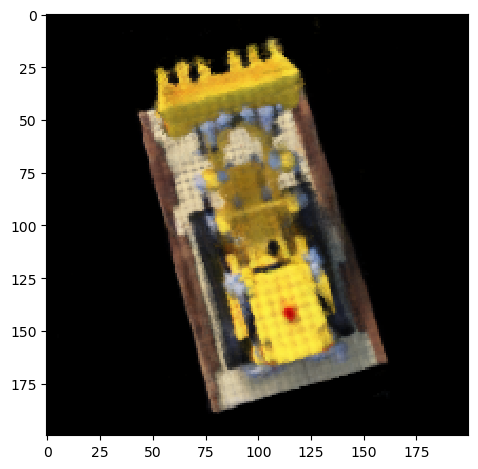

In [110]:

skio.imshow(results)
skio.imsave("iteration%s.jpg"%5000, results)
# skio.imsave("r_5000.jpg",results)

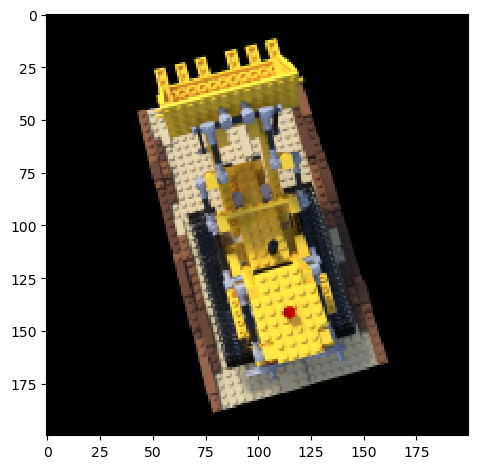

In [190]:
skio.imshow(images_val[0])

In [116]:
for index in range(len(c2ws_test)):
    print("saving: ", index)
    model.eval()
    eval_height = 200
    eval_width = 200
    # c2w_eval = c2ws_train[index]
    c2w_eval = c2ws_test[index]
    results = np.zeros((eval_height, eval_width,3))
    for i in range(eval_height):
        uv = []
        for j in range(eval_width):
            uv.append([i,j])
        ray_o, ray_d = pixel_to_ray(K, c2w_eval, uv)
        rays_o = np.repeat(ray_o, eval_height, axis=0)
        rays_d = list(ray_d)
    
        rays_o = torch.tensor(rays_o).float().to(device)
        rays_d = torch.tensor(rays_d).float().to(device)
        points = sample_along_rays(rays_o, rays_d, perturb=False)
        points = points.to(device)
        # rays_d = torch.tensor(rays_d).to(device)
        rays_d = torch.unsqueeze(rays_d,1)
        rays_d = rays_d.repeat(1,n_samples,1)
        rays_d = rays_d.view(-1,3)
        
        rgbs, sigmas = model(points, rays_d)
        rgbs = rgbs.to(device)
        sigmas = sigmas.to(device)
        # sigams = model.foward_dentisy()
        sigmas = sigmas.view(-1, n_samples, 1)
        rgbs = rgbs.view(-1, n_samples, 3)
        
        rendered_colors = volrend(sigmas, rgbs, step_size).detach().cpu().numpy()
    
        # print(rendered_colors.shape)
        results[:,i,:] = rendered_colors
    save_file_path = 'test_results/%s.png'%index  # Change the file extension as needed (e.g., .jpg, .png, .bmp, etc.)

    # Save the NumPy array as an image using skimage
    skio.imsave(save_file_path, results)

saving:  0


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  1


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  2


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  3


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  4


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  5


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  6


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  7


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  8


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  9


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  10


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  11


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  12


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  13


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  14


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  15


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  16


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  17


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  18


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  19


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  20


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  21


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  22


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  23


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  24


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  25


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  26


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  27


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  28


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  29


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  30


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  31


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  32


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  33


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  34


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  35


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  36


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  37


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  38


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  39


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  40


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  41


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  42


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  43


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  44


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  45


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  46


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  47


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  48


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  49


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  50


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  51


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  52


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  53


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  54


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  55


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  56


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  57


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  58


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  59


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
